* * * * * * * * * * *
Master notebook to run every step of the analyses of the Z0 experiment in python.

Author: Rodrigo Guedes Lang (rodrigo.lang@fau.de)

Date: March 2024

Based on scripts by Kathrin Valerius and Jannik Hofestaedt from 2011-2013
* * * * * * * * * * *

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from PIL import Image
from IPython.display import display

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Part 1 - Qualitative analysis of events

In this part of the experiment, the main idea is to look at a small subset of Monte Carlo (MC) events to build up insight on how events from each channel look like on average. The final good is to come up with some crude cuts to separate the channels.

## Part 1.1 - GROPE event display

### Exercises

1.1. For each channel, describe qualitatively the features of its events.

1.2. Come up with a 4x4 table describing which variables are important for separating each pair of channels

1.3. Choose an example data set (?-?) and just by looking at the GROPE image, try to evaluate with the channel for each event.

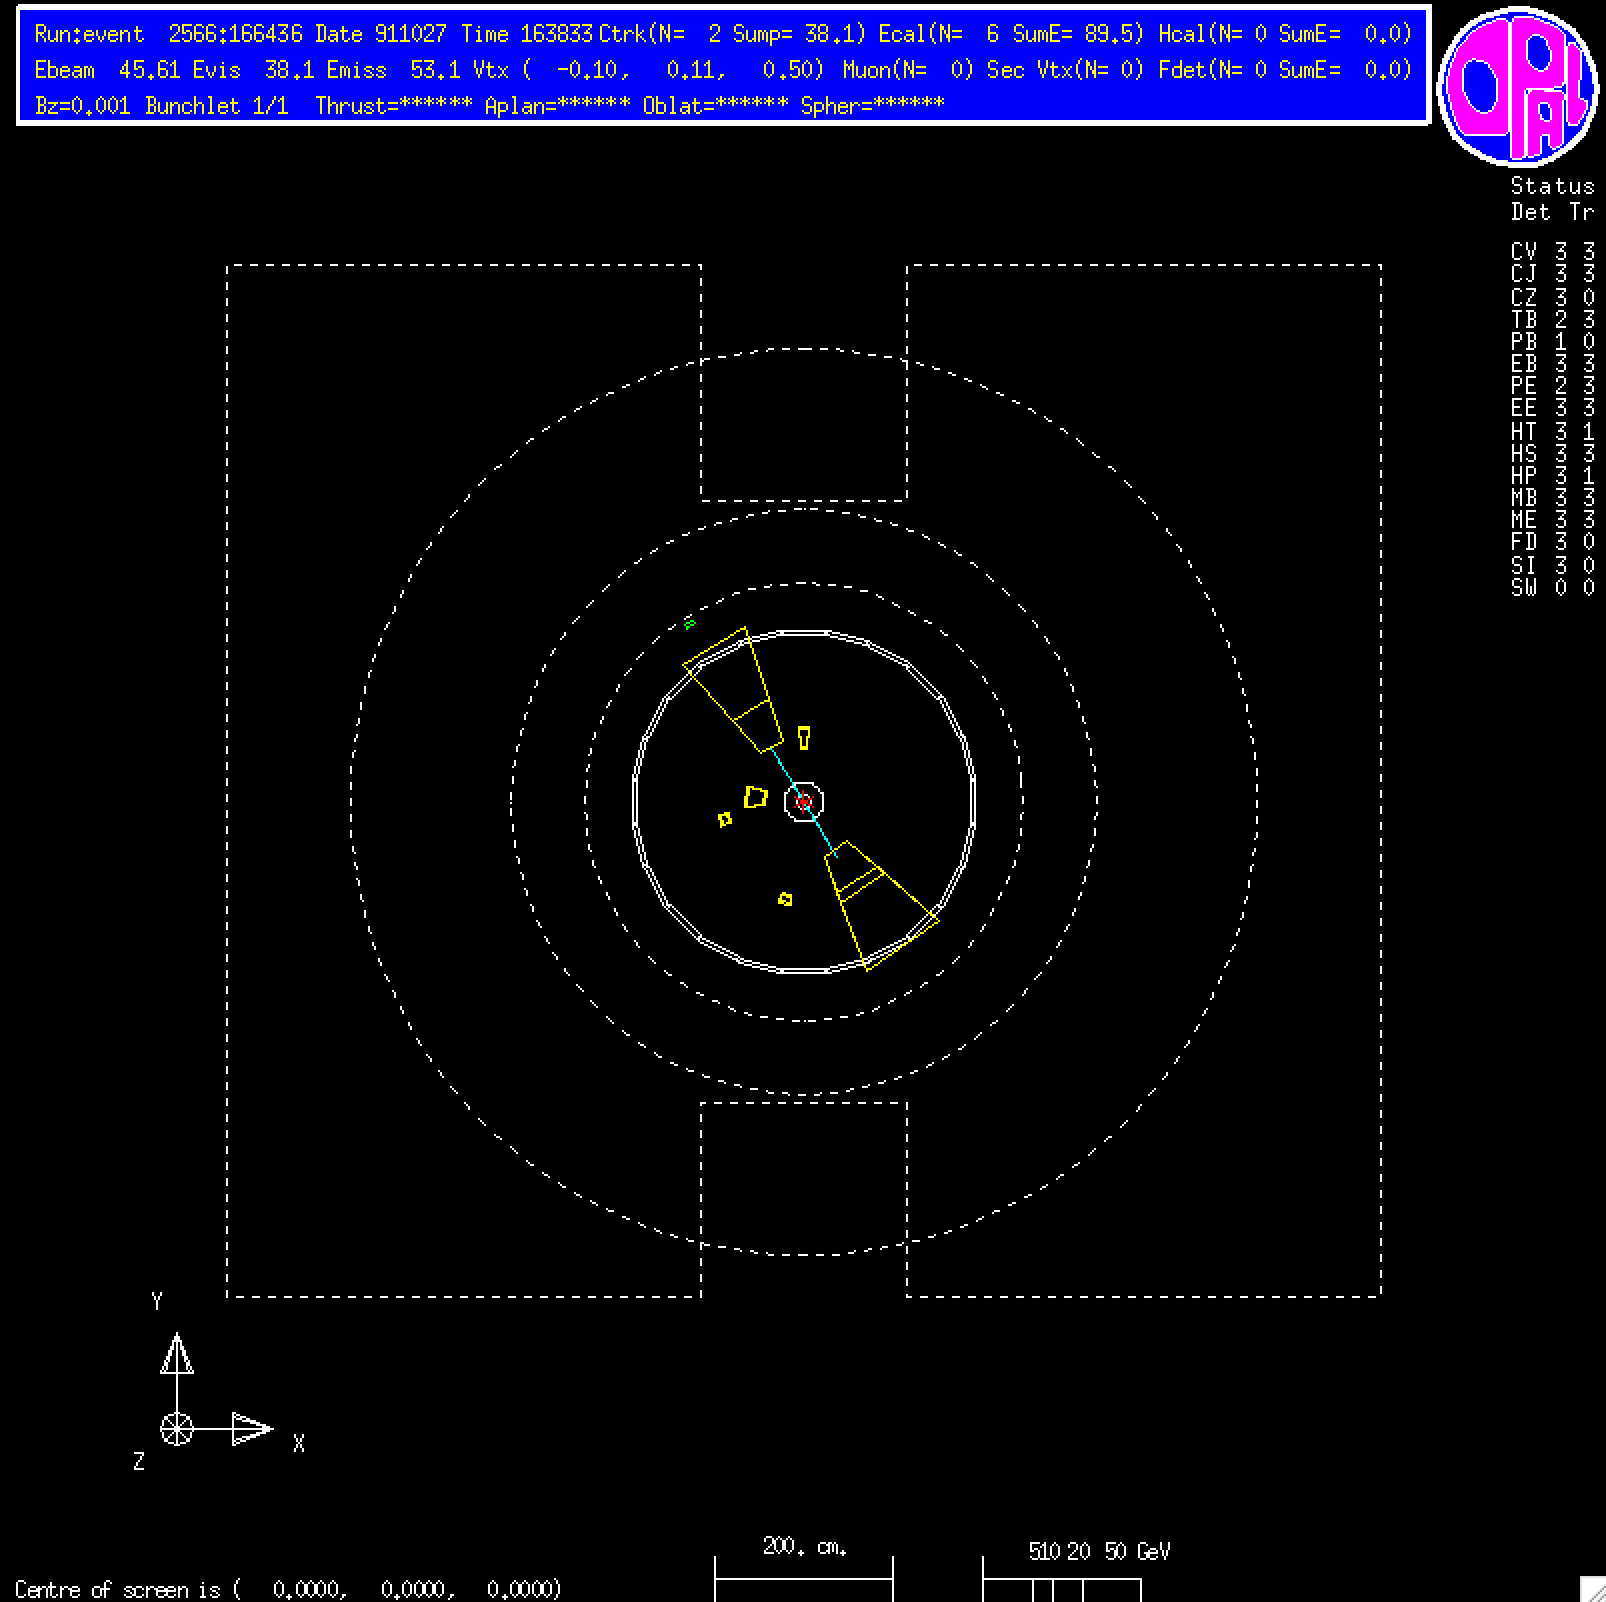

In [5]:
display(Image.open('../Data/GROPEScreenshots/ee/5.png'))

# Part 2 - Quantitative analysis of events

Looking at singular events may help understanding how they look like in the detector. Nevertheless, due to the stochastic nature of the processes involved, each event will look quite differently and we need to look at event distributions.

In the previous part, we have dealt with very few MC events to create a better insight on what their properties and differences are. In this part, we will move on to a much larger set of MC events so that more complete and well-described distributions can be analysed. From here on, information and images of single events will not be used anymore.

## Part 2.1 - Generating histograms

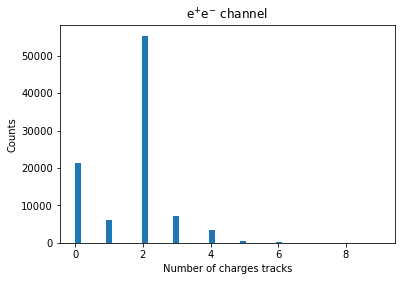

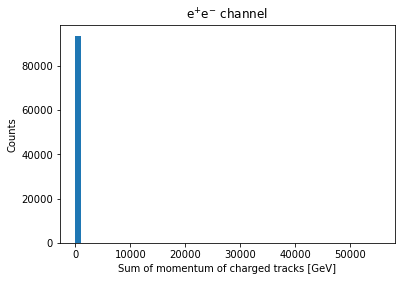

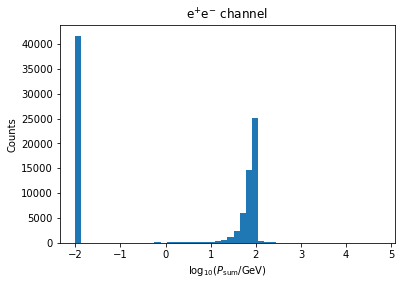

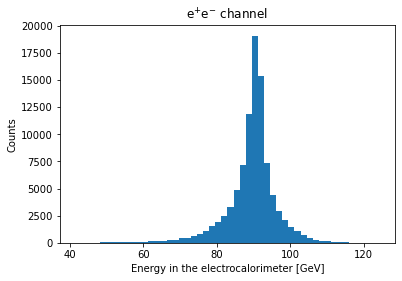

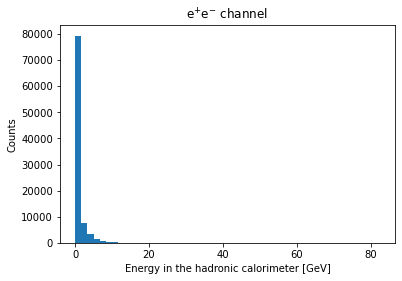

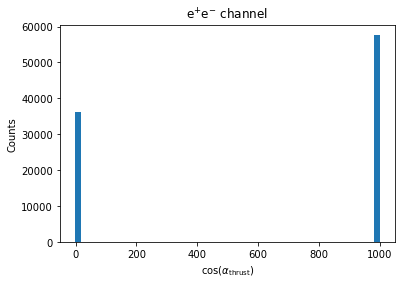

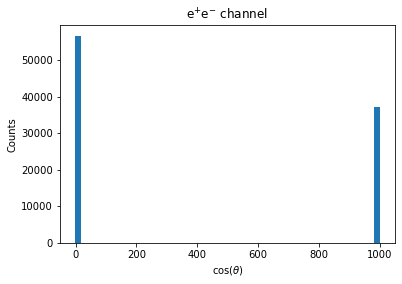

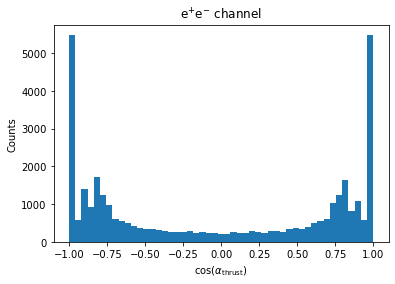

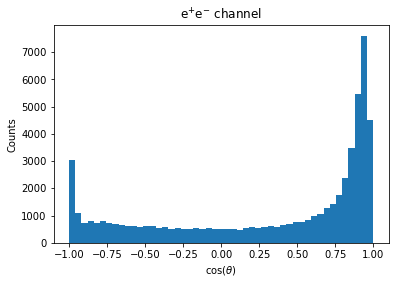

In [29]:
# Example for a single channel

file = uproot.open("../Data/MC/ee.root")
tree = file['h3']

Ncharged = np.array(tree['Ncharged'].array())
Pcharged = np.array(tree['Pcharged'].array())
E_ecal = np.array(tree['E_ecal'].array())
E_hcal = np.array(tree['E_hcal'].array())
cos_thru = np.array(tree['cos_thru'].array())
cos_thet = np.array(tree['cos_thet'].array())


plt.hist(Ncharged,bins=50)
plt.xlabel("Number of charges tracks")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(Pcharged,bins=50)
plt.xlabel("Sum of momentum of charged tracks [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(np.log10(Pcharged+0.01),bins=50)
plt.xlabel(r"$\log_{10} (P_{\rm{sum}} / \rm{GeV})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(E_ecal,bins=50)
plt.xlabel("Energy in the electrocalorimeter [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(E_hcal,bins=50)
plt.xlabel("Energy in the hadronic calorimeter [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(cos_thru,bins=50)
plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(cos_thet,bins=50)
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(cos_thru,bins=np.linspace(-1,1,50))
plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

plt.hist(cos_thet,bins=np.linspace(-1,1,50))
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.show()

### Questions

Three plots were "redefined".

1. For $P_{\rm{sum}}$, we used log10 (and had to add 0.01). Why?
2. For the angles, we need to constrain to the physical values, i.e., $-1 < \cos(\theta) < 1$. What happened to the events with unphysical angles?

### Exercises

2.1.0. Every plot in this protocol/example notebook has been plotted with the standard style options. Are these the best options in general? For each case? Do you think you can come up with better looking/easier to read plots?

2.1.1. Obtain the same histogram for the other three channels (the input root files are located in the same folder).

2.1.2. Come up with a nice way to show the comparison between the four channels

## Part 2.2 - Separating s-t channels

For $\rm{e^{+}e^{-}}$ channel, not only annihiliation processes (s-channel) are present, but also scattering processes (t-channel). Nevertheless, the Z0 boson can only be produced in the first one and, thus, only those events contribute to the decay width. For that reason, those events must also be selected out.

The two channels differ on their angular distribution:

$\frac{d\sigma}{d\Omega} \alpha \left\{\begin{array}{@{}lr@{}}
        1+\cos^2(\theta), & \text{s-channel}\\
        (1-\cos \theta)^{-2}, & \text{t-channel}\\
        \end{array}\right.$

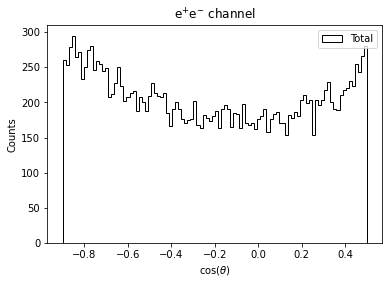

In [45]:
file = uproot.open("../Data/MC/ee.root")
tree = file['h3']

cos_thet = np.array(tree['cos_thet'].array())

# A first safe cos_theta cut must be applied

mask_safe = (cos_thet>-0.9) & (cos_thet<0.5)

data_hist = plt.hist(cos_thet[mask_safe],bins=np.linspace(-0.9,0.5,101),color='black',label='Total',histtype='step')
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

We now define a fit function of the type:

$a (1+\cos^2(\theta)) + b (1-\cos \theta)^2$

where $a$ and $b$ are free parameters

In [54]:
def fitFunction(x,a,b):
    
    return(a*(1+x*x) + b*1/(1-x)**2)

Fitted parameters:
a = 156.06058060297522 +- 1.7458651889197494
b = 16.390767863718597 +- 1.5615445741301004


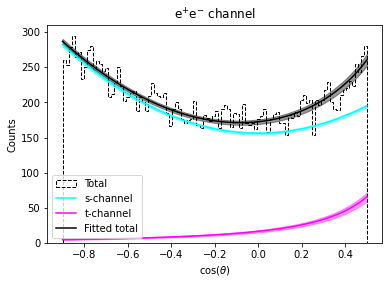

In [62]:
popt, pcov = curve_fit(fitFunction, data_hist[1][:-1] + (data_hist[1][1] - data_hist[1][0])/2., data_hist[0], bounds=(0,10000))
print("Fitted parameters:")
print(f"a = {popt[0]} +- { np.sqrt(np.diag(pcov))[0] }")
print(f"b = {popt[1]} +- { np.sqrt(np.diag(pcov))[1] }")

plt.hist(cos_thet[mask_safe],bins=np.linspace(-0.9,0.5,101),color='black',label='Total',histtype='step',linestyle='--')
plt.plot(np.linspace(-0.9,0.5,101),popt[0] * (1+np.linspace(-0.9,0.5,101) ** 2),label='s-channel',color='cyan')
plt.fill_between(np.linspace(-0.9,0.5,101),(popt[0]-np.sqrt(np.diag(pcov))[0]) * (1+np.linspace(-0.9,0.5,101) ** 2),(popt[0]+np.sqrt(np.diag(pcov))[0]) * (1+np.linspace(-0.9,0.5,101) ** 2),alpha=0.4,color='cyan')
plt.plot(np.linspace(-0.9,0.5,101),popt[1] * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,label='t-channel',color='magenta')
plt.fill_between(np.linspace(-0.9,0.5,101),(popt[1]-np.sqrt(np.diag(pcov))[1]) * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,(popt[1]+np.sqrt(np.diag(pcov))[1]) * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,alpha=0.4,color='magenta')
plt.plot(np.linspace(-0.9,0.5,101),popt[0] * (1+np.linspace(-0.9,0.5,101) ** 2) + popt[1] * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,color='black',label='Fitted total')
plt.fill_between(np.linspace(-0.9,0.5,101),(popt[0]-np.sqrt(np.diag(pcov))[0]) * (1+np.linspace(-0.9,0.5,101) ** 2) + (popt[1]-np.sqrt(np.diag(pcov))[1]) * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,(popt[0]+np.sqrt(np.diag(pcov))[0]) * (1+np.linspace(-0.9,0.5,101) ** 2) + (popt[1]+np.sqrt(np.diag(pcov))[1]) * 1/(1-np.linspace(-0.9,0.5,101)) ** 2,alpha=0.4,color='black')

plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

### Exercises

Using the results of the fit:

2.2.1. Calculate the fraction of s-channel events in the region $\cos \theta \in [-0.9,0.5]$

2.2.2. Calculate the total number of s-channel events in $\cos \theta \in [-1,1]$

In [64]:
fracSChannel = ?? # from 2.2.1.
totalSChannel = ?? # from 2.2.2.

SyntaxError: invalid syntax (648708920.py, line 1)

## Part 2.3 - Defining selection cuts

As we just learned, events cannot be singularly defined, but they can be defined by their distributions. The idea of this part if to come up with four sets of cuts to separate the four channels

0.001300611927251018 (122/93802) events of channel ee surviving example random cuts
0.00122 (122/100000) events of channel ee surviving example random cuts


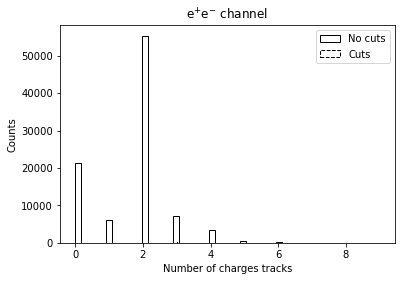

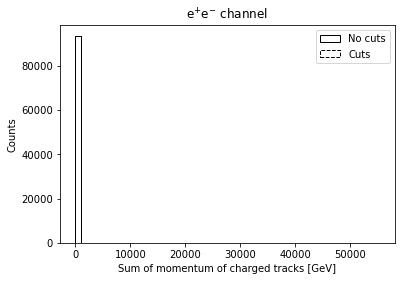

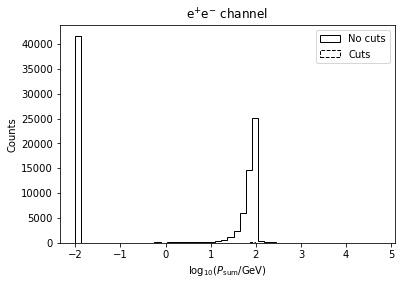

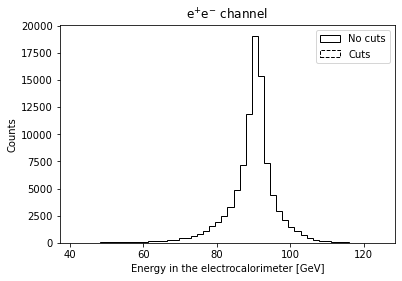

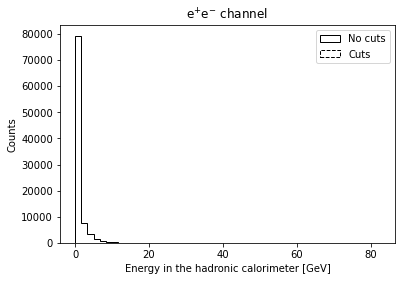

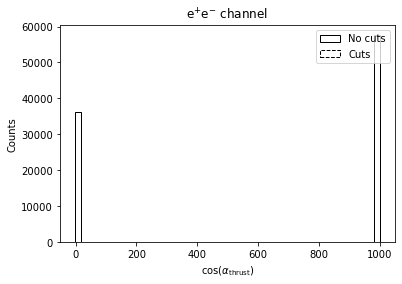

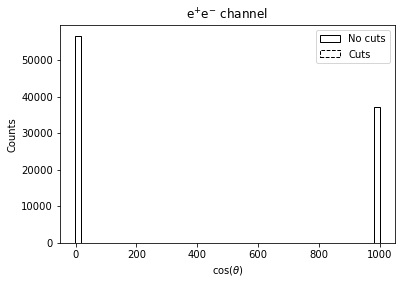

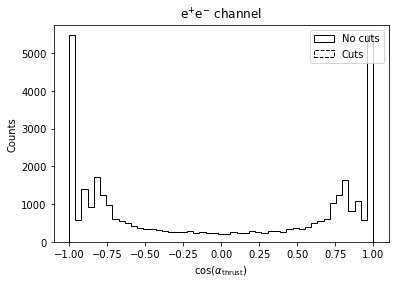

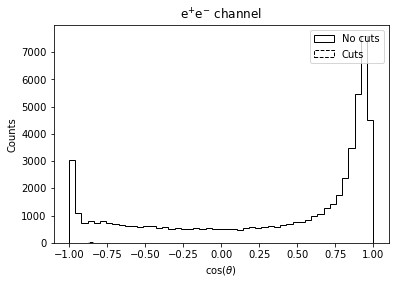

In [65]:
# Example for a single channel

file = uproot.open("../Data/MC/ee.root")
tree = file['h3']

Ncharged = np.array(tree['Ncharged'].array())
Pcharged = np.array(tree['Pcharged'].array())
E_ecal = np.array(tree['E_ecal'].array())
E_hcal = np.array(tree['E_hcal'].array())
cos_thru = np.array(tree['cos_thru'].array())
cos_thet = np.array(tree['cos_thet'].array())

mask_safe = mask_safe = (cos_thet>-0.9) & (cos_thet<0.5) # If looking for ee, this cut must be kept due to the s-t contamination! For other channels this can (and maybe should) be taken out
mask = (mask_safe) & (Ncharged > 2) & (Ncharged < 10) & (cos_thru > -0.7) & (E_ecal < 100) # completely random cuts, just to show the syntax needed!

print(f"{len(E_ecal[mask])/len(E_ecal)} ({len(E_ecal[mask])}/{len(E_ecal)}) events of channel ee surviving example random cuts")
print(f"{len(E_ecal[mask])/100000} ({len(E_ecal[mask])}/100000) events of channel ee surviving example random cuts")

plt.hist(Ncharged,bins=50,color='black',label='No cuts',histtype='step')
plt.hist(Ncharged[mask],bins=50,color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel("Number of charges tracks")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

plt.hist(Pcharged,bins=50,color='black',label='No cuts',histtype='step')
plt.hist(Pcharged[mask],bins=50,color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel("Sum of momentum of charged tracks [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

plt.hist(np.log10(Pcharged+0.01),bins=50,color='black',label='No cuts',histtype='step')
plt.hist(np.log10(Pcharged[mask]+0.01),bins=50,color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel(r"$\log_{10} (P_{\rm{sum}} / \rm{GeV})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

plt.hist(E_ecal,bins=50,color='black',label='No cuts',histtype='step')
plt.hist(E_ecal[mask],bins=50,color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel("Energy in the electrocalorimeter [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

plt.hist(E_hcal,bins=50,color='black',label='No cuts',histtype='step')
plt.hist(E_hcal[mask],bins=50,color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel("Energy in the hadronic calorimeter [GeV]")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

plt.hist(cos_thru,bins=50,color='black',label='No cuts',histtype='step')
plt.hist(cos_thru[mask],bins=50,color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

plt.hist(cos_thet,bins=50,color='black',label='No cuts',histtype='step')
plt.hist(cos_thet[mask],bins=50,color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

plt.hist(cos_thru,bins=np.linspace(-1,1,50),color='black',label='No cuts',histtype='step')
plt.hist(cos_thru[mask],bins=np.linspace(-1,1,50),color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel(r"$\cos(\alpha_{\rm{thrust}})$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

plt.hist(cos_thet,bins=np.linspace(-1,1,50),color='black',label='No cuts',histtype='step')
plt.hist(cos_thet[mask],bins=np.linspace(-1,1,50),color='black',linestyle='--',label='Cuts',histtype='step')
plt.xlabel(r"$\cos(\theta)$")
plt.ylabel("Counts")
plt.title(r"$\rm{e^{+}e^{-}}$ channel")
plt.legend()
plt.show()

### Exercises

2.3.1. Come up with four sets of cuts, one for each channel and show the impact on the histograms for every channel for each cut.

2.3.2. Build a 4x4 matrix containing the fraction of events of MC simulations of channel $i$ surviving the cuts to select events of channel $j$.

2.3.3. Correct all the entries in the matrix for MC simulations of channel e+e- in order to keep only s-channel events using the numbers fracSChannel and totalSChannel calculated in the previous step.

### Questions

1. There are two numbers to calculate the fraction of surviving events. Either dividing by the number of events without cuts or diving by 100000 which is the initial number of MC simulations. Why are those numbers different? Which one should be used?
2. In an ideal world how do we expect this 4x4 matrix to look like?
3. How can measure which of two possible 4x4 matrices is better?

In [70]:
acceptanceMatrix = np.array([[?,?,?,?],[?,?,?,?],[?,?,?,?],[?,?,?,?]]) # between 0-1
correctedAcceptanceMatrix = np.array([[?,?,?,?],[?,?,?,?],[?,?,?,?],[?,?,?,?]]) # corrected after s-t separation
totalNumberOfEvents = np.array([[?,?,?,?],[?,?,?,?],[?,?,?,?],[?,?,?,?]]) # real number of events used in the calculation

SyntaxError: invalid syntax (3190737071.py, line 1)

# Part 3 - Getting the physical results

Now that we spent time learning from MC simulations how each channel works and quantitatively estimated the response of our analysis. We can apply it to real data, in which we cannot know what is the real channel that created that event.

With that we can estimate what was the initial total number of events in each channel and, thus, calculate the cross section and decay width.

## Part 3.1 - Calculate the number of real data events after cuts

From data, we have the total number of detected events for each energy bin, $k$, $N^{k}_{\rm{det}}$. We then apply each of our 4 cuts for each channel $j$, getting the number of detected events in each energy bin, $k$ and for each cut, $j$: $N^{j,k}_{\rm{det}}$

In [74]:
# Table with energy bins, don't change this

energy_bins = [44,44.5,45,45.4,45.8,46.2,46.7,47.2]

In [75]:
# Example for reading data and applying cuts

# Choose a dataset from 1, 2, 4, 5 or 6 (3 was faulty and therefore deleted)

dataset = 1

file = uproot.open(f"../Data/Real/daten_{dataset}.root")
tree = file['h33']

Ncharged = np.array(tree['Ncharged'].array())
Pcharged = np.array(tree['Pcharged'].array())
E_ecal = np.array(tree['E_ecal'].array())
E_hcal = np.array(tree['E_hcal'].array())
cos_thru = np.array(tree['cos_thru'].array())
E_lep = np.array(tree['E_lep'].array())
cos_thet = np.array(tree['cos_thet'].array())

mask_safe = mask_safe = (cos_thet>-0.9) & (cos_thet<0.5) # If looking for ee, this cut must be kept due to the s-t contamination! For other channels this can (and maybe should) be taken out
mask = (mask_safe) & (Ncharged > 2) & (Ncharged < 10) & (cos_thru > -0.7) & (E_ecal < 100) # completely random cuts, just to show the syntax needed!

for i in range(7): # loop over energy bins
    mask_total = mask & (E_lep > energy_bins[i]) & (E_lep < energy_bins[i+1])
    print(f"Number of real data events surviving random cuts in energy bins {i}: {mask_total.sum()}")

Number of real data events surviving random cuts in energy bins 0: 1
Number of real data events surviving random cuts in energy bins 1: 1
Number of real data events surviving random cuts in energy bins 2: 3
Number of real data events surviving random cuts in energy bins 3: 38
Number of real data events surviving random cuts in energy bins 4: 8
Number of real data events surviving random cuts in energy bins 5: 6
Number of real data events surviving random cuts in energy bins 6: 4


### Exercises

3.1.1. Get the vector $N_{\rm{det}}$ with the number of real data events surviving each set of cuts

In [ ]:
N_det = np.array([?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?])

## Part 3.2 - Estimate the initial number of events in each channel

$N_{\rm{det}}$ doesn't represent the real number of initial events in each channel, because some events are cut out with the cuts and there is some cross contamination. This however is estimate by our acceptance matrix, $A$. We can, therefore, obtain $N_{init}$ by:

$N^{k}_{\rm{det}} = A N^{k}_{\rm{init}} \implies N^{k}_{\rm{init}} = A^{-1} N^{k}_{\rm{det}}$


### Exercises

3.2.1. Get the vector $N_{\rm{init}}$ by applying the inverted corrected acceptance matrix on the vector calculated in the previous step

In [76]:
N_init = np.array([?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?],
                 [?,?,?,?])

SyntaxError: invalid syntax (3787486108.py, line 1)

## Part 3.3 - Estimate the cross sections without errors

Now that we estimated the real initial number of events in each channel, we can estimate the energy-dependent cross section for each channel.

The cross-section is given by:

$\sigma_{i}(E_{k}) = \frac{N_{i,j}}{L_{k}} + \eta_{i,k}$,

where $\rm{corr}$ are the radiation corrections (here given to you)

In [4]:
# Radiation correction

radcorr_lep = np.array([0.09,0.2,0.36,0.52,0.22,-0.01,-0.08])
radcorr_had = np.array([2.0,4.3,7.7,10.8,4.7,-0.2,-1.6])

# Luminosity and energy bins for each of the given datasets

LEP_energies = {}
LEP_luminosities = {}
LEP_luminosities_error = {}

LEP_energies[1] = np.array([88.48021,89.47158,90.22720,91.23223,91.97109,92.97091,93.71841])
LEP_luminosities[1] = np.array([675.8590,543.6270,419.7760,3122.204,639.8380,479.2400,766.8380])
LEP_luminosities_error[1] = np.array([3.502185,3.179205,2.810879,7.786547,3.567344,3.121618,3.972102])

LEP_energies[2] = np.array([88.47777,89.46906,90.22324,91.23965,91.96968,92.97059,93.71714])
LEP_luminosities[2] = np.array([371.9800,488.5300,378.5461,2072.793,540.6800,369.4000,353.5000])
LEP_luminosities_error[1] = np.array([2.594937,3.009684,2.670417,6.334670,3.274401,2.737608,2.695570])

LEP_energies[4] = np.array([88.47939,89.46793,90.22266,91.22430,91.96648,92.96465,93.71712])
LEP_luminosities[4] = np.array([463.9790,667.5236,486.7641,2246.568,535.9080,450.6000,709.6980])
LEP_luminosities_error[1] = np.array([2.902361,3.521166,3.033955,6.603405,3.265110,3.027953,3.819882])

LEP_energies[5] = np.array([88.47939,89.46957,90.23120,91.23193,91.97322,92.96836,93.71712])
LEP_luminosities[5] = np.array([463.9790,472.6636,510.2150,3898.628,518.6880,624.5900,709.6980])
LEP_luminosities_error[1] = np.array([2.902361,2.964559,3.099458,8.694719,3.213012,3.564113,3.819882])

LEP_energies[6] = np.array([88.48021,89.46928,90.22604,91.24186,91.96859,92.96836,93.71685])
LEP_luminosities[6] = np.array([675.8590,800.8436,873.7021,7893.498,825.2780,624.5900,942.2280])
LEP_luminosities_error[1] = np.array([3.502185,3.855322,4.057872,12.37099,4.051215,3.564113,4.403135])

In [5]:
# Read the proper values for the dataset you have chosen in 3.1

energies = LEP_energies[dataset]
luminosities = LEP_luminosities[dataset]
luminosities_error = LEP_luminosities[dataset]

NameError: name 'dataset' is not defined

### Exercises

3.3.1. Calculate the cross section for each energy and channel for the chosen data set.

3.3.2. Plot the cross section as a function of energy for the four channels.

## Part 3.4 - Fit a Breit-Wigner function to the cross sections

Once the cross sections have been calculated, the physical quantities of the Z0-boson can be retrieved by fitting the expected Breit-Wigner cross section to the data:

$\frac{a}{\frac{4 (x-b)^2}{c^2} + \left(\frac{x}{b}\right)^2}$

### Questions

1. What physical characteristic of the Z0 does each of the free parameters, $a$, $b$ and $c$ correspond to?

### Exercises

3.4.1. Fit a Breit-Wigner function to each of the channels.

3.4.2. Plot the measured data (as in 3.3.2) together with the fitted function. Present the error in the fit function as a shaded area.

(The cells of 2.2. may be useful examples here :D)

In [6]:
def BreitWigner(x,a,b,c):
    return(a/(4./(c**2) * ((x - [b])**2) + (x/[b])**2))

In [ ]:
# fit example

popt, pcov = curve_fit(BreitWigner, energies, crosssection)

## Part 3.5 - Calculate errors in the cross section data

In the previous part, the fit was done disregarding statistical uncertainties in the measured data. This means that different poins are considered equally into the fit, even tough they shouldn't. In this section we present the calculation of the errors in $\Delta \sigma_{i,k}$.

In order to calculate the final $\Delta \sigma_{i,k}$, we first need to evaluate the statistical uncertainties in each of the terms, i.e., $\Delta L_{k}$, $\Delta N^{j,k}_{\rm{det}}$ and $\Delta A_{i,j}^{-1}$.

*Luminosity*

The uncertainties in the luminosity, $\Delta L_{k}$ were given above.

*Number of measured events*

The uncertainties in the measured events is purely Poissonian, therefore: $\Delta N_{\rm{det}}^{j,k} = \sqrt{N_{\rm{det}}^{j,k}}$

*Acceptance matrix*

The uncertainties in the acceptance matrix are $\Delta A_{i,j} = \sqrt{A_{i,j} (1-A_{i,j})}$

*Inverted acceptance matrix*

The uncertainties in the INVERTED acceptance matrix are $\Delta A^{-1} = A^{-1} \Delta A A^{-1}$

Finally, via error propagation:

$\sigma_{i,k} = \frac{\Sigma_j A_{i,j}^{-1} N_{\rm{det}}^{j,k}}{L_{k}}$

$\implies \Delta \sigma_{i,k} = \sqrt{\Sigma_j \left(\Delta A^{-1}_{i,j} \frac{N_{\rm{det}}^{j,k}}{L_{k}}\right)^2 + \Sigma_j \left( \Delta N_{\rm{det}}^{j,k} \frac{A^{-1}_{i,j}}{L_{k}} \right)^2 + \Sigma_j \left( \Delta L_k \frac{A^{-1}_{i,j} N_{\rm{det}}^{j,k}}{L^2_k}\right) }$

### Exercises

3.5.1. Calculate the statistical uncertainties on the cross sections for each energy and channel.

3.5.2. Plot the cross section showing the statistical uncertainties.

## Part 3.6 - Fit of the data considering errors

Finally, we can now fit the data considering the errors in the data, as it should be.

### Exercises

3.6.1. Refit the data, now considering the statistical uncertainties.

3.6.2. Plot the data with errors and the fitted functions.

3.6.3. Calculate the $\chi^2/\rm{NDF}$ for each channel.

### Questions

1. What does the $\chi^2/\rm{NDF}$ mean?

2. What range of $\chi^2/\rm{NDF}$ denotes a good fit? What happens outside of this range?

3. How good was the fit you just got?

In [ ]:
# Example to run the fit with errors

popt, pcov = curve_fit(BreitWigner, energies, crosssection, sigma=delta_crosssection,absolute_sigma=True)